In [1]:
!pip install texthero
!pip install rouge

     |████████████████████████████████| 235 kB 7.7 MB/s 
     |████████████████████████████████| 1.5 MB 36.3 MB/s 
     |████████████████████████████████| 749 kB 48.4 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [2]:
#importing libraries
import texthero as hero
from rouge import Rouge
from string import digits, punctuation
import torch
import time
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import string 
import os
import re
import queue
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# reading the dataset
df_more = pd.read_csv('/content/drive/MyDrive/LSTM/news_summary_more.csv',)
df_more.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [5]:
# calculating the length of the senetnce
df_more['head_len'] = df_more['headlines'].apply(lambda x : len(x.split(' ')))
df_more['text_len'] = df_more['text'].apply(lambda x : len(x.split(' ')))

In [6]:
df_more.head()

,headlines,text,head_len,text_len
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",13,60
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,12,60
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,9,60
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",9,60
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,13,60


In [7]:
# maximum length of the headlines and text
df_more['head_len'].max(), df_more['text_len'].max()

(18, 92)

In [8]:
# dropping the unnecesary columns
df_more.drop(['head_len', 'text_len'], axis=1, inplace=True)

In [9]:
#renaming columns
df_more.columns = ['highlights', 'stories']

In [10]:
df = df_more.copy(deep=True)

In [11]:
# to attach the device to tensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device to run the code on GPU

In [12]:
# convertin to str
df['stories'] = df['stories'].astype(str)
df['highlights'] = df['highlights'].astype(str)

# removing digits
remove_digits = str.maketrans('', '', digits)
df['stories'] = df['stories'].apply(lambda x : x.translate(remove_digits))
df['highlights'] = df['highlights'].apply(lambda x : x.translate(remove_digits))

df['stories_len'] = df['stories'].apply(lambda x : len(x.split(' ')))
df['highlights_len'] = df['highlights'].apply(lambda x : len(x.split(' ')))
df.head()

,highlights,stories,stories_len,highlights_len
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",60,13
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,60,12
2,New Zealand end Rohit Sharma-led India's -matc...,New Zealand defeated India by wickets in the ...,60,9
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",60,9
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,60,13


In [13]:
# selecting the samples having max sentence length = 60
max_sentence_length = 60
df = df[df['stories_len'] <= max_sentence_length]
df.shape

(91208, 4)

In [14]:
# pre-processing the entire dataset
df['stories'] = hero.clean(df['stories'])
df['highlights'] = hero.clean(df['highlights'])

# adding the start and the end token
df['stories'] = df['stories'].apply(lambda x : 'sos ' + x + ' eos')
df['highlights'] = df['highlights'].apply(lambda x : 'sos ' + x + ' eos')

In [15]:
# reading the numpy values
stories_ = df.iloc[:,1].values
highlights_ = df.iloc[:,0].values
output_len =  df.iloc[:,3].values

In [16]:
# downloading the word embedding 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-12-09 05:21:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-09 05:21:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-09 05:21:38--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [17]:
# reading the word eme
embedding_dict = dict()
f = open('/content/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coef = np.asarray(values[1:],dtype='float32')
    embedding_dict[word] = coef 
f.close()

In [18]:
# create vocab
words = [] 

for line in stories_:
    for word in line.split(' '):
        words.append(word)

for line in highlights_:
    for word in line.split(' '):
        words.append(word)

In [19]:
# return svocabulary of the datsset
vocab = sorted(Counter(words), key=Counter(words).get, reverse=True)

In [20]:
embed_dim = 300
words_found = 0
words_OOV = 0
word2idx = {}
word2idx['<pad>'] = 0

for index, word in enumerate(vocab):
    word2idx[word] = index+1

weight_embedding = np.zeros([len(vocab)+1,embed_dim],dtype='float32')

In [21]:
# creating the weight matrix for traniing and calculating out of vocabulary words
for i, word in enumerate(vocab):
    try:
        weight_embedding[i,:] = embedding_dict[word]
        words_found += 1
    except:
        weight_embedding[i,:] = np.random.normal(scale=0.6, size=[embed_dim,])
words_found        

57554

In [22]:
# converting pre-trained word embedding dictionary to the numpy array
weight_embedding = torch.from_numpy(weight_embedding)

In [23]:
# to integers

stories_num = []
highlights_num = []

for w in stories_:
    sentence = []
    for word in w.split():
        sentence.extend([word2idx[word]])
    stories_num.append(sentence)

for w in highlights_:
    sentence = []
    for word in w.split():
        sentence.extend([word2idx[word]])
    highlights_num.append(sentence)

In [24]:
# max length of summary and the text
max_story_len = 60 
max_summary_len = 18
story_feature = np.zeros((len(stories_num),max_story_len),dtype=int)
highlight_feature = np.zeros((len(highlights_num),max_summary_len), dtype=int)

# creating the numy array of the datset 
for i, row in enumerate(stories_num):
    story_feature[i,:len(row)] = np.array(row)[:max_story_len]
for i, row in enumerate(highlights_num):
    highlight_feature[i,:len(row)] = np.array(row)[:max_summary_len]

In [25]:
# train test split
split_index = int(len(story_feature)*0.8)
train_story, test_story = story_feature[:split_index],story_feature[split_index:]
train_highlight, test_highlight = highlight_feature[:split_index],highlight_feature[split_index:]

In [26]:
# splits the dattaset
split_index = int(len(test_story)*0.1)
val_story, test_story  = test_story[:split_index],test_story[split_index:]
val_highlight, test_highlight  = test_highlight[:split_index],test_highlight[split_index:]

In [27]:
val_story.shape, test_story.shape, train_story.shape

((1824, 60), (16418, 60), (72966, 60))

In [28]:
val_highlight.shape, test_highlight.shape, train_highlight.shape

((1824, 18), (16418, 18), (72966, 18))

In [29]:
# initializes the LSTM model embedding layer
def create_emb(weight_matrix, non_trainable=False):
    emb_layer = torch.nn.Embedding(weight_matrix.shape[0],weight_matrix.shape[1])
    emb_layer.load_state_dict({'weight': weight_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False 
    return emb_layer

In [30]:
# LSTM model encoder network
class Encoder(nn.Module):
    def __init__(self, dropout, num_hidden, layers, weight_matrix, embed_dim, device):
        super(Encoder,self).__init__()
        self.layers = layers
        self.num_hidden = num_hidden
        self.device = device
        self.embed_dim = embed_dim
        
        self.dropout = torch.nn.Dropout(dropout)
        self.embedding = create_emb(weight_matrix,True)
        # encoder LSTM
        self.lstm = torch.nn.LSTM(input_size = self.embed_dim,hidden_size = self.num_hidden,
                                  num_layers = self.layers,batch_first=True,dropout=0.5,
                                 bidirectional=True)
    def forward(self,x,hidden):
        x = self.embedding(x)
        lstm_in = self.dropout((x))
        output,(h_hidden,c_hidden) = self.lstm(lstm_in,hidden)
       
        h = torch.cat((h_hidden[-1,:,:],h_hidden[-2,:,:]),1)
        c = torch.cat((c_hidden[-1,:,:],c_hidden[-2,:,:]),1)

        hidden = (h.unsqueeze(0),c.unsqueeze(0))
       
        return output, hidden
    
    def init_hidden(self,batch_size):
        # initialize the hidden state as the zero tensor
        weight = next(self.parameters()).data
        hidden = (weight.new(self.layers*2,batch_size, self.num_hidden).zero_(),
                  weight.new(self.layers*2, batch_size, self.num_hidden).zero_())
        return hidden

In [31]:
# attention decoder network with pointer mechanism
class AttentionDecoder(nn.Module):
    def __init__(self,num_hidden,dropout,vocab_size,layers,weight_matrix,embed_dims,device):
        super(AttentionDecoder,self).__init__()
        self.num_hidden = num_hidden
        self.dropout = dropout
        self.layers = layers
        self.vocab_size = vocab_size
        self.embed_dims = embed_dims
        self.device = device
        self.dropout_layer = torch.nn.Dropout(self.dropout)
        
        self.V = torch.nn.Linear(self.num_hidden,1)
        
        self.generator = torch.nn.Linear(2*self.num_hidden+self.embed_dims,1)
        self.output_layer = torch.nn.Linear(2*self.num_hidden,self.vocab_size)
        self.softmax = torch.nn.Softmax(dim=1)
        self.lstm = torch.nn.LSTM(input_size = self.num_hidden+self.embed_dims,hidden_size = self.num_hidden,
                                  num_layers = self.layers,batch_first=True,dropout=0.5,
                                 bidirectional=False)
        self.embedding = create_emb(weight_matrix,True)
        self.sig = torch.nn.Sigmoid()
        self.device = device
        
    # forward computation
    def forward(self,x,enc_out,hidden,text,batch_size):
        x = self.embedding(x).unsqueeze(1)
        x = self.dropout_layer(x)
        
        dec_a = hidden[0].permute(1,0,2)
        enc_score = self.V(torch.tanh(enc_out + dec_a)) # attention score
        enc_weight = self.softmax(enc_score) # attention weight
        enc_context = torch.mul(enc_weight,enc_out) # find the context vector
        enc_context = enc_context.sum(1)
        enc_context.unsqueeze_(1)
        
        d_in = torch.cat((x,enc_context),2)
        
        d_output, hidden = self.lstm(d_in,hidden)
        output = torch.cat((d_output.squeeze(1),enc_context.squeeze(1)),1)
        
        output_generator = torch.cat((enc_context.squeeze(1),d_output.squeeze(1),x.squeeze(1)),1)
        
        # pointer mechanism
        p_gen = self.sig(self.generator(output_generator).squeeze(1))
        
        p_pointer = 1 - p_gen
        pointer_prob = torch.zeros([batch_size,self.vocab_size],device=self.device)
        for i in range(batch_size):
            pointer_prob[i,text[i,:]] = enc_weight[i,:,0] # pointer probability weights are the attention scores
        generator_prob = self.output_layer(output) # output layer to get vocabulary probability
        output_probability = torch.mul(p_pointer.unsqueeze(1),pointer_prob) + torch.mul(p_gen.unsqueeze(1),generator_prob)
        
        return output_probability, hidden
    
    def init_hidden(self,batch_size):
        # initialize the hidden state as the zero tensor
        weight = next(self.parameters()).data
        hidden = (weight.new(self.layers, batch_size, 2*self.num_hidden).zero_(),
                  weight.new(self.layers, batch_size, 2*self.num_hidden).zero_())
        return hidden

In [32]:
#model hyperparameters
dropout = 0.5
num_hidden = 256 
enc_layers = 1 
batch_size = 256
vocab_size = len(word2idx) 
dec_layers = 1 
embed_dims = 300  

In [33]:
# yiedls batch of data while training the model
def get_batches(x, y,batch_size=16):
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [34]:
class BeamNode(object):
    def __init__(self,hidden_state,seq,prob,length,loss):
        self.hidden = hidden_state
        self.seq = seq
        self.prob = prob
        self.len = length
        self.loss = loss
        self.s = self.score()
        
    def score(self):
        return self.prob/float(self.len-1+1e-6) # calculates the score of a sequence

# initializes the LSTM attention and pointer model 
class Seq2Seq(nn.Module):
    def __init__(self,dropout,num_hidden,enc_layers,weight_embedding,
                vocab_size,dec_layers,embed_dims,device):
        super(Seq2Seq, self).__init__()
        self.vocab_size = vocab_size
        self.device = device
        self.encoder = Encoder(dropout,num_hidden,enc_layers,weight_embedding,embed_dims,device)
        self.decoder = AttentionDecoder(2*num_hidden,dropout,vocab_size,dec_layers,weight_embedding,embed_dims,device)
    
    def forward(self,x,target,e_hidden,criterion,batch_size):
        # training the decoder
        loss = 0
        prediction = target[:,0].unsqueeze(1) 
        enc_output,enc_hidden = self.encoder(x,e_hidden) 
        d_hidden = enc_hidden 
        dec_input = target[:,0] 
        for t in range(1,target.shape[1]):
            logits, d_hidden = self.decoder(dec_input,enc_output,d_hidden,x,batch_size)
            dec_input = target[:,t] # teacher forcing turned on 
            loss += criterion(logits,target[:,t]) # calculate the loss function
            prediction = torch.cat((prediction,torch.argmax(logits,dim=0).unsqueeze(1)),0)
        return loss, prediction 
    
    # greedy loss
    def inference_greedy(self,x,target,e_hidden,criterion,batch_size):
        loss = 0
        prediction = target[:,0].unsqueeze(1) 
        enc_output,enc_hidden = self.encoder(x,e_hidden) 
        d_hidden = enc_hidden 
        dec_input = target[:,0] 

        for t in range(1,target.shape[1]):
            # run the decoder
            logits, d_hidden = self.decoder(dec_input,enc_output,d_hidden,x,batch_size)
            dec_input = torch.argmax(logits,dim=1)
            loss += criterion(logits,target[:,t]) # calculate the loss
            prediction = torch.cat((prediction,torch.argmax(logits,dim=0).unsqueeze(1)),0)
        return loss, prediction

    # used to predict the output senetence after training the model
    def infer(self,x,target,e_hidden,batch_size):
        loss = 0
        prediction = target[:,0].unsqueeze(1) 
        enc_output,enc_hidden = self.encoder(x,e_hidden) 
        d_hidden = enc_hidden 
        dec_input = target[:,0] 

        li = np.zeros((256, 18))
        i = 0

        for t in range(1,target.shape[1]):
            # run the decoder
            logits, d_hidden = self.decoder(dec_input,enc_output,d_hidden,x,batch_size)
            dec_input = torch.argmax(logits,dim=1)
            li[:, i] = torch.argmax(logits, dim=1).cpu()
            i += 1
        return li
    
    # for calculating the beam loss
    def inference_beam(self,x,target,e_hidden,criterion,beam_width,batch_size):
        decoded = [] 
        losses = 0
        enc_output,enc_hidden = self.encoder(x,e_hidden) # run the encoder
        for i in range(batch_size):
            # for each sentence in the batch
            prediction = target[i,0].view([1]).unsqueeze(1) 
            dec_hidden = enc_hidden[0].permute(1,0,2)[i,:,:].unsqueeze(0)
            dec_input = target[i,0].view([1])
            d_hidden = (enc_hidden[0][:,i,:].unsqueeze(0),enc_hidden[1][:,i,:].unsqueeze(0))
            first_node = BeamNode(d_hidden,dec_input,0,1,0) 
            nodes = queue.PriorityQueue(maxsize=beam_width) 
            nodes.put((-first_node.score(),first_node))
            for t in range(1,target.shape[1]):
                candidatenodes = [] 
                candidatescore = [] 
                donenodes = [] 

                
                for _ in range(nodes.qsize()):
                    # for each sequence in the queue
                    sc,nodex = nodes.get()
                    seq = nodex.seq.view([-1,1]) 
                    dec_input = seq[-1,:] 
                    hidden = nodex.hidden 
                    d_hidden = (hidden[0],hidden[1]) 

                    if dec_input == word2idx['eos']:
                        donenodes.append((sc,nodex))
                    else:
                        # run the decoder
                        logits, d_hidden = self.decoder(dec_input,enc_output[i,:,:].unsqueeze(0),d_hidden,x,batch_size=1)
                        # calculate the loss
                        loss = criterion(logits,target[i,t].view([1]))
                        # pick the top 10 logits values
                        log_p, index = torch.topk(logits,beam_width)
                        for k in range(beam_width):
                            node = BeamNode(d_hidden, torch.cat([nodex.seq,index[0,k].unsqueeze(0)]),nodex.prob+log_p[0][k],nodex.len+1,nodex.loss+loss)
                            score = -node.score()
                            candidatenodes.append([score,node])
                for score,n in donenodes:
                    nodes.put((score,n))
                for score,n in candidatenodes[nodes.qsize():beam_width]:
                    nodes.put((score,n))
            _,output_node = nodes.get()
            
            decoded.append(output_node.seq)
            losses+=output_node.loss
            del nodes
        return losses/batch_size,decoded
    

In [ ]:
# hyperparameters of the model
epochs = 5
batch_size = 256
learning_rate = 0.001

#initializing the model
model = Seq2Seq(dropout,num_hidden,enc_layers,weight_embedding,
                vocab_size,dec_layers,embed_dims,device).to(device)

#model sscheduler and optimizer object
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)
counter = 0
loss = []

# predicts 3 sentences at each step
beam_width = 3 

# iterating the model over the given number of epochs
for e in range(epochs):
    start_time = time.time() # start timer
    p = np.random.permutation(train_highlight.shape[0])
    train_story = train_story[p,:]
    train_highlight = train_highlight[p,:]
    e_hidden = model.encoder.init_hidden(batch_size)
    
    for x,y in get_batches(train_story,train_highlight,batch_size):
        model.train()

        # attching cuda to the tensor
        x = torch.from_numpy(x).to(device)
        y = torch.from_numpy(y).to(device)
        
        e_hidden = tuple([each.data for each in e_hidden])
        #zeroing out the gradient
        optimizer.zero_grad()

        # model prediction
        l,prediction = model(x,y,e_hidden,criterion,batch_size)
        loss.append(l.item()) 
        l.backward()
        nn.utils.clip_grad_norm_(model.parameters(),2) 
        optimizer.step() 
        
        print("Epoch: {}/{} \tStep: {} \tLoss: {:.4f} ".format(e+1, epochs, counter,l.item()))
        counter += 1
        

    torch.save(model.state_dict(), '/content/drive/MyDrive/LSTM/weight.pth')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1



Epoch: 1/5 	Step: 0 	Loss: 123.8170 
Epoch: 1/5 	Step: 1 	Loss: 123.4164 
Epoch: 1/5 	Step: 2 	Loss: 133.8129 
Epoch: 1/5 	Step: 3 	Loss: 121.4609 
Epoch: 1/5 	Step: 4 	Loss: 116.5439 
Epoch: 1/5 	Step: 5 	Loss: 123.1975 
Epoch: 1/5 	Step: 6 	Loss: 104.8104 
Epoch: 1/5 	Step: 7 	Loss: 92.4947 
Epoch: 1/5 	Step: 8 	Loss: 96.6749 
Epoch: 1/5 	Step: 9 	Loss: 93.7161 
Epoch: 1/5 	Step: 10 	Loss: 94.5865 
Epoch: 1/5 	Step: 11 	Loss: 98.9296 
Epoch: 1/5 	Step: 12 	Loss: 98.4534 
Epoch: 1/5 	Step: 13 	Loss: 96.5698 
Epoch: 1/5 	Step: 14 	Loss: 97.1911 
Epoch: 1/5 	Step: 15 	Loss: 95.4838 
Epoch: 1/5 	Step: 16 	Loss: 97.7337 
Epoch: 1/5 	Step: 17 	Loss: 92.6184 
Epoch: 1/5 	Step: 18 	Loss: 95.7796 
Epoch: 1/5 	Step: 19 	Loss: 97.6994 
Epoch: 1/5 	Step: 20 	Loss: 95.7214 
Epoch: 1/5 	Step: 21 	Loss: 96.1197 
Epoch: 1/5 	Step: 22 	Loss: 96.4624 
Epoch: 1/5 	Step: 23 	Loss: 100.5777 
Epoch: 1/5 	Step: 24 	Loss: 94.2840 
Epoch: 1/5 	Step: 25 	Loss: 94.0927 
Epoch: 1/5 	Step: 26 	Loss: 92.6575 
Epo

In [35]:
# loading the weights of the pre-trained model
model = Seq2Seq(dropout,num_hidden,enc_layers,weight_embedding,
                vocab_size,dec_layers,embed_dims,device).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/LSTM/weight.pth'))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1



<All keys matched successfully>

#  Beam Search Loss

In [38]:
# beam search decoder
with torch.no_grad():
    beam_time = time.time() # start timer
    loss_beam = [] 
    beam_predict = [] # save beam search decoder outputs
    highlight_validation = [] # save validation target summaries
    story_validation = [] # save validation input text
    model.eval()
    # initialize the encoder hidden state
    val_hidden = model.encoder.init_hidden(batch_size)
    for x_val, y_val in get_batches(val_story, val_highlight,batch_size):
        # convert data to PyTorch tensor
        x_val = torch.from_numpy(x_val).to(device)
        y_val = torch.from_numpy(y_val).to(device)
        val_hidden = tuple([each.data for each in val_hidden])
        # run the beam search decoder
        val_loss, prediction = model.inference_beam(x_val, y_val,val_hidden,criterion,beam_width=3,batch_size=256)
        loss_beam.append(val_loss.item())
        beam_predict.append(prediction)
        highlight_validation.append(y_val)
        story_validation.append(x_val)
    model.train()
    print("Beam Test: {0} s".format(time.time()-beam_time))
    print("Val Beam Search Loss: {:.4f}".format(np.mean(loss_beam)))

Beam Test: 143.65502405166626 s
Val Beam Search Loss: 22.6244


In [39]:
# predicting the output
result = []

with torch.no_grad():
    beam_time = time.time() # start timer
    loss_beam = [] 
    beam_predict = [] # save beam search decoder outputs
    highlight_validation = [] # save validation target summaries
    story_validation = [] # save validation input text
    model.eval()
    # initialize the encoder hidden state
    val_hidden = model.encoder.init_hidden(batch_size)

    for x_val, y_val in get_batches(val_story[:batch_size*7], val_highlight[:batch_size*7],batch_size):
        # convert data to PyTorch tensor
        x_val = torch.from_numpy(x_val).to(device)
        y_val = torch.from_numpy(y_val).to(device)
        val_hidden = tuple([each.data for each in val_hidden])
        # run the beam search decoder
        temp = model.infer(x_val, y_val,val_hidden,batch_size=256)
        result.append(temp)
    model.train()

In [40]:
#index to word dictionary
idx2word = dict((v,k) for k,v in word2idx.items())

In [41]:
# concatenating the actual output
def concatenate__reference(refer):

  op = refer[: batch_size, :]

  for i in range(1, 7):
    op = np.append(op, refer[batch_size*i : batch_size*(i+1), :], axis=0)
  return op

reference = concatenate__reference(val_highlight)

In [42]:
# concatenating all the predicted result
def concatenate_result_model_output(output):

  op = output[0]

  for i in range(1, 7):
    op = np.append(op, output[i], axis=0)
  return op

model_out = concatenate_result_model_output(result)

In [43]:
# converting index to word 
def numpy_to_str(array_):

  result = []
  for i in range(array_.shape[0]):

    temp = ""
    for j in range(array_.shape[1]):
      temp += idx2word[array_[i][j]] + ' '
    result.append(temp)
  return result
  
reference = numpy_to_str(reference)
model_out = numpy_to_str(model_out)

In [46]:
# calculates rouge score
rouge = Rouge()
scores = rouge.get_scores(reference, model_out, avg=True)

In [47]:
scores

{'rouge-1': {'f': 0.4121747902755441, 'p': 0.26212201736755253, 'r': 1.0},
 'rouge-2': {'f': 0.1394088826340569,
  'p': 0.0924504857122046,
  'r': 0.3108258928571428},
 'rouge-l': {'f': 0.4121747902755441, 'p': 0.26212201736755253, 'r': 1.0}}

# Comparison

### **Pointer and Attention mechanism**  
#### 1. ROUGE SCORE
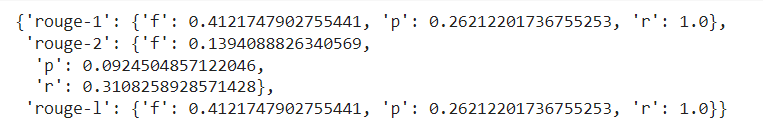

#### 2. CrossEntropyLoss (change in loss over epoch)
##### Epoch-1 (123)  to  Epoch-5 (80)
<br>


### **Vanilla LSTM**
#### 1. ROUGE SCORE
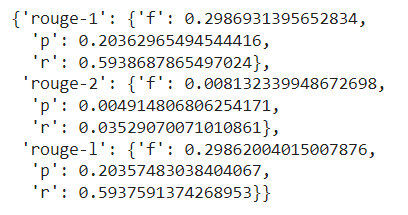

#### 2. CrossEntropyLoss (change in loss over epoch)
##### Epoch-1 (11)  to  Epoch-5 (7.05)